# MiniGato

From the paper [A Generalist Agent](https://arxiv.org/abs/2205.06175).

The paper doesn't introduce a new architecture. Instead, the paper is all about tokenizing, embedding, and sequencing data from multiple modalities (text, image, proprioception) in such a way that it can be learned by a transformer.

Reproducing the paper is more of a software design exercise than an ML research exercise. How would you structure the data manipulation code – the tokenization, embedding, and sequencing of different modalities – in a way that's correct, easy to understand and extend, and performant?

### Imports

In [ ]:
from collections import OrderedDict
from itertools import cycle
import math
import os
from pathlib import Path
import random
import re
import tempfile
from typing import List, Protocol
from dataclasses import dataclass, fields
import datasets
from einops import rearrange
from functools import partial
from mugato.nano_gpt import GPT, GPTConfig
import numpy as np
import matplotlib.pyplot as plt
import minari
from mugato.utils import TransformDataset
import minigrid.core
import PIL
import random
import requests
from timm.models.resnetv2 import ResNetV2
import tiktoken
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision.transforms.functional import pil_to_tensor as _pil_to_tensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

torch.manual_seed(42)
random.seed(42)

# Check for TPU support (requires torch_xla library)
try:
    import torch_xla.core.xla_model as xm
    tpu_available = xm.xla_device_hw() == "TPU"
except ImportError:
    tpu_available = False

# Set device based on availability
if tpu_available:
    device = xm.xla_device()  # For GCP TPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # For NVIDIA GPUs
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # For Apple Silicon (macOS with MPS)
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f"Using device: {device}")

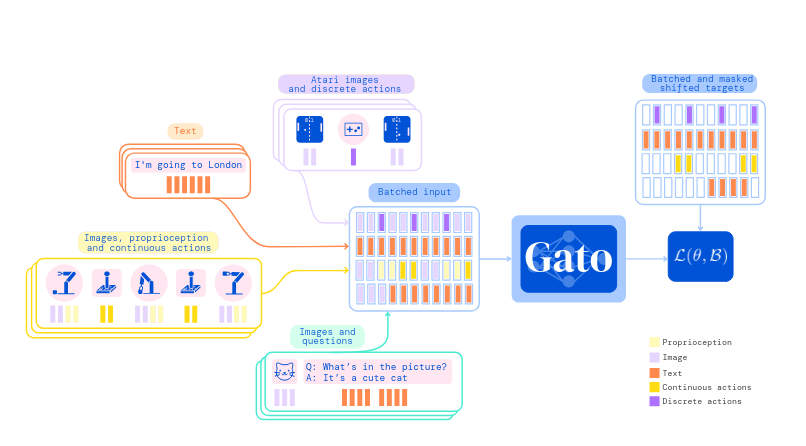

### Tokenizing and sequencing

We're going to be dealing with a bunch of different datasets of a bunch of different modalities.

Here's some examples

- A text dataset where each sample is a UTF-8 string.
- A visual-question answering dataset where each sample is a dictionary of image (PIL format), question, and answer.
- A visual-question answering dataset where each sample is a dictionary of image, question, and a list of 10 answers of different confidence levels.
- A grid-world dataset where each sample is a sequence of observations, where each observation is a dictionary of discrete view of the world, discrete state of the agent, and action the agent took.

If we can find a common format, a common shape, between all of our datasets, then our model will remain simple. That's what we want. We want to minimze the complexity of our model, so it's easy to verify it's working correctly; easy to experiment with.

A batch of text data might start out as something like:

```
[
  ["Four score and seven years ago..."],
  ["There once was a man from Nantucket..."],
  ["Lorem ipsum dolor sit amet..."],
]
```

Which might get tokenized (with padding) as a shape (3, 11) batch of tensors:

```
tensor([[15137,  4776,   290,  3598,   812,  2084,   986,     0,     0,     0,     0],
        [ 1858,  1752,   373,   257,   582,   422,   399,   415, 38811,   986,     0],
        [   43, 29625,   220,  2419,   388,   288, 45621,  1650,   716,   316,   986]])
```

And then embedded to something like (3, 512) if we have 512 embedding dimensions.

That's simple enough. We could send that straight into a model.

What about an agent episode?

```
[
    [
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x479>",
            "observation_direction": 0,
            "action": 2,
        },
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x479>",
            "observation_direction": 1,
            "action": 1,
        },
        # ...
    ],
    [
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>",
            "observation_direction": 1,
            "action": 3,
        },
        # ...
    ],
    [
        {
            "observation_image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x458>",
            "observation_direction": 0,
            "action": 1,
        },
        # ...
    ],
]
```

That's going to be trickier.

Consider the first sample in that batch.

The GATO paper describes sequencing each episode like this:

```
[<observation_image_0>, <observation_direction_0>, <action_separator_0>, <action_0>, <observation_image_1>, <observation_direction_1>, <action_separator_1>, <action_1>, ...]
```

That would be great if each of those placeholders expanded to a single token, or even a list of tokens.

The `direction` and `action` will get tokenized to a number at the end of the text tokenizers vocab size. [[§2.1 Tokenization](https://arxiv.org/pdf/2205.06175#page=3)]

```
[<observation_image_0>, 50257, 51281, 50258, ...]
```

But think about how you encode an image as "tokens".

The paper describes splitting an image into "patches". 16x16 of them. Each patch then gets sent through ResNetV2. Each "token" is more like an "embedding" in terms of its shape.

```
[[[0.13... -0.54..., 0.79...], [0.03... 0.67..., 0.88...], ...], 50257, 51281, 50258, ...]
```

You can't really *sequence* those like you could text. Not yet at least. Not as tensors - you'd need each token to have the same shape to concat them. Once you embed discrete values using a lookup table, then you can combine the images and text into a sequence. But until then, we'll have to keep them separated.

In [ ]:
examples = [
    {
        # Continuous/Discrete/Text looks like this:
        #
        #                                 Episodes
        #                                 |  Tokens
        #                                 |  |  Channels
        #                                 |  |  |
        'mission': torch.arange(2*4).view(2, 4, 1),
        # Images look like this:
        #
        #                                      Episodes
        #                                      |  Height
        #                                      |    |    Width
        #                                      |    |    |  Channels
        #                                      |    |    |  |
        'image': torch.randn(2*256*256*3).view(2, 256, 256, 3),
        'action': torch.arange(2*1).view(2, 1, 1),
    },
    {
        'mission': torch.arange(3*3).view(3, 3, 1),
        'image': torch.randn(3*256*256*3).view(3, 256, 256, 3),
        'action': torch.arange(3*1).view(3, 1, 1),
    },
]

Those examples would be batched (collated?) to actually look like the following.

Notice that padding.

- The first example had its ***episodes*** padded to 3.
- The second example had its ***mission tokens*** padded to 4.

In [ ]:
batch = {
    # Continuous/Discrete/Text looks like this:
    #                                   Batch
    #                                   |  Episodes
    #                                   |  |  Tokens
    #                                   |  |  |  Channels
    #                                   |  |  |  |
    'mission': torch.arange(2*3*4).view(2, 3, 4, 1),
    # Images look like this:
    #                                        Batch
    #                                        |  Episodes
    #                                        |  |  Height
    #                                        |  |    |  Width
    #                                        |  |    |    |  Channels
    #                                        |  |    |    |  |
    'image': torch.randn(2*3*256*256*3).view(2, 3, 256, 256, 3),
    'action': torch.arange(2*3*1).view(2, 3, 1, 1),
}

### Setup

Boilerplate utility functions to help with demos/examples. (You'll see these redefined later. I need the code now due to way code cells run linearly. But I don't want to show the details until later.)

In [ ]:
tempfile.gettempdir()

In [ ]:
def pil_to_tensor(p):
    return _pil_to_tensor(p) if isinstance(p, PIL.Image.Image) else p
# I'm going to load some datasets early so that we have some examples to work with as we build stuff.

def acquire_shakespeare_dataset():
    xdg_data_home = Path(os.environ.get("XDG_DATA_HOME", os.path.expanduser("~/.local/share")))
    shakespeare_filepath = xdg_data_home/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)

    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset

shakespeare_dataset = acquire_shakespeare_dataset()
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)

In [ ]:
print(shakespeare_dataset[0])

## Tokenization [§ 2.1](https://arxiv.org/pdf/2205.06175)

> There are infinite possible ways to transform data into tokens, including directly using the raw underlying byte stream.

Some of this notebook deviates slightly (insignificantly, I expect) from the Gato paper.

- Text is encoded via `tiktoken`'s [r50k_base](https://github.com/openai/tiktoken/blob/63527649963def8c759b0f91f2eb69a40934e468/tiktoken_ext/openai_public.py#L33)
- Images are transformed into sequences of non-overlapping 16x16 patches in raster order, as done in [ViT (Dosovitskiy et al., 2020)](https://arxiv.org/pdf/2010.11929).
- Discrete values, e.g. Atari button presses, are flattened into sequences of integers within the range [50257, 51280) – the 1023 tokens after the text tokenizer's range. Discrete token 51281 (the 1024th discrete token) is used as the separator token between an observation and an action.
- Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values, then mu-law encoded to the range [-1, 1], then discretized into 1024 uniform bins, then encoded the same as discrete values.
- Discrete observations that represent a grid-like environment (i.e. [Minigrid](https://minigrid.farama.org/environments/minigrid/)) are transformed into images and encoded as such. This might be the most significant change. The Gato paper describes flattening these types of discrete observation values. That loses the benefit of neighboring column/row patch position encoding of images. Plus this is extra image training data for free.

### Tokenizing images

> Images are first transformed into sequences of non-overlapping 16 × 16 patches in raster order, as done in ViT (Dosovitskiy et al., 2020). Each pixel in the image patches is then normalized between [−1, 1] and divided by the square-root of the patch size (i.e. √16 = 4).

**Why divide by the square root of the patch size?**

Dividing by $\sqrt{\text{patch\_size}}$ helps maintain proper scaling of the activations as signals flow through the network. This normalization technique helps control the variance of the activations.

We'll use 144 patches (12 by 12) to keep our model a bit smaller and faster. The patch size will still be 16. That means our images need to be resized to 192 by 192 before patching.

In [ ]:
image_transform = transforms.Compose([
    pil_to_tensor,
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
    # Normalizing helps with training but makes images look weird.
    # We'll add it later, after we've visually inspected the process.
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
def normalize_to_between_minus_one_plus_one(t: torch.Tensor):
    min_val, max_val = t.min(), t.max()
    if min_val == max_val:
        return torch.zeros_like(t)
    normalized = 2 * (t - min_val) / (max_val - min_val) - 1
    return normalized

In [ ]:
xs = torch.arange(-2, 5)
normalize_to_between_minus_one_plus_one(xs)

In [ ]:
# A single image, patched, will take the shape (144, 16, 16, 3)
# 144 patches of 16x16 pixels with 3 color channels.
# We want to normalize each patch independently.
# This function will help us with that.
def apply_along_dimension(func, dim, tensor):
    tensor = tensor.transpose(0, dim)
    shape = tensor.shape
    tensor = tensor.reshape(shape[0], -1)
    result = torch.stack([func(tensor[:, i]) for i in range(tensor.size(1))], dim=1)
    result = result.reshape(shape).transpose(0, dim)
    return result

In [ ]:
# I like to visualize the effect of functions like this, to help build intuition.
example = torch.arange(8).view(2, 2, 2)
print(f"starting tensor:\n{example}\n")
print(f"t * t.min() along dim 0:\n{apply_along_dimension(lambda t: t * t.min(), 0, example)}\n")
print(f"t * t.min() along dim 1:\n{apply_along_dimension(lambda t: t * t.min(), 1, example)}\n")
print(f"t * t.min() along dim 2:\n{apply_along_dimension(lambda t: t * t.min(), 2, example)}\n")

In [ ]:
example_image = vqa_dataset['train'][0]['image']
example_image

In [ ]:
def image_to_patches(image, patch_size=16):
    return rearrange(image, 'c (h s1) (w s2) -> (h w) (c s1 s2)', s1=16, s2=16)

# We don't need this as part of Gato. It's just here to play with and visually test the code.
def patches_to_image(patches, image_shape, patch_size=12):
    channels, height, width = image_shape
    patch_height = height // patch_size
    patch_width = width // patch_size
    reconstructed = rearrange(
        patches,
        '(h w) (c p1 p2) -> c (h p1) (w p2)',
        h=12,
        w=12,
        c=3,
        p1=16,
        p2=16,
    )
    return reconstructed

In [ ]:
example_image_patches = image_to_patches(image_transform(example_image))
image_transform(example_image).shape, example_image_patches.shape

In [ ]:
patches_matplotlib_dims = rearrange(example_image_patches, 'p (s0 s1 s2) -> p s1 s2 s0', s0=3, s1=16, s2=16)
patches_matplotlib_dims.shape

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=12, figsize=(8, 1))

for i in range(2):
    for j in range(12):
        axes[i, j].imshow(patches_matplotlib_dims[i*12+j])
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
image_to_patches(image_transform(example_image)).shape

In [ ]:
def encode_image(image, patch_size=16):
    patches = image_to_patches(image, patch_size=patch_size)
    xs = (
        apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 1, patches
        )
        / math.sqrt(patch_size)
    )
    return xs

def decode_image(tokens, image_shape=(3, 192, 192), patch_size=16):
    # Slightly lossy because I'm not saving the values used for scaling from encoding.
    patches = apply_along_dimension(
        lambda x: (x * math.sqrt(patch_size) + 1) / 2,
        1,
        tokens
    )
    images = patches_to_image(patches, image_shape, patch_size=patch_size)
    return images

# # Instead of normalizing each patch independently
# def encode_image(image, patch_size=16):
#     normalized_image = normalize_to_between_minus_one_plus_one(image)
#     patches = image_to_patches(normalized_image, patch_size=patch_size)
#     xs = patches / math.sqrt(patch_size)
#     return xs

# def decode_image(tokens, image_shape=(3, 192, 192), patch_size=16):
#     patches = tokens * math.sqrt(patch_size)
#     images = patches_to_image(patches, image_shape, patch_size=patch_size)
#     return images

In [ ]:
sample_image_encoded = encode_image(image_transform(example_image))
sample_image_encoded.shape, sample_image_encoded.mean(), sample_image_encoded.std()

In [ ]:
# Lossy because I'm not storing the min/max from normalization.
plt.imshow(decode_image(sample_image_encoded).permute(1, 2, 0))

### Tokenizing text

This one's easy.

In [ ]:
def encode_text(text_tokenizer, text):
    tokens = torch.tensor(text_tokenizer.encode(text))
    return tokens

def decode_text(text_tokenizer, tokens):
    return text_tokenizer.decode(tokens.tolist())
text_tokenizer = tiktoken.get_encoding("r50k_base")
encode_text(text_tokenizer, "Hello, world!"), decode_text(text_tokenizer, encode_text(text_tokenizer, "Hello, world!"))

### Tokenizing discrete

> Discrete values, e.g. Atari button presses, are flattened into sequences of integers in row-major order. The tokenized result is a sequence of integers within the range of [0, 1024).
> 
> ...
> 
> The discrete integers are then shifted to the range of [32000, 33024).

In our case, it will be [50257, 51281), since we're using the GPT2 tokenizer, which has a vocab size of 50256, instead of the SentencePiece tokenizer that the paper uses, which has a vocab size of 32000.

In [ ]:
def as_tensor(x):
    return x if isinstance(x, torch.Tensor) else torch.tensor(x)

# Same asymmetry story as above.
def encode_discrete(xs, n_text):
    return torch.tensor(xs, dtype=torch.long).unsqueeze(-1) + n_text

def decode_discrete(tokens, n_text):
    # The model might output a token below the discrete vocabulary.
    # (The discrete vocabulary is 0-1023 shifted by n_text.)
    # How should we deal with tokens that decode (token - self.n_text)
    # to negative tokens? I say we don't. Leave that to the application.
    return (tokens % n_text).squeeze(-1).tolist()
[
    encode_discrete([0, 2, 2, 1, 3], text_tokenizer.n_vocab), 
    decode_discrete(encode_discrete([0, 2, 2, 1, 3], text_tokenizer.n_vocab), text_tokenizer.n_vocab)
]

### Tokenizing continuous

> Continuous values, e.g. proprioceptive inputs or joint torques, are first flattened into sequences of floating point values in row-major order. The values are mu-law encoded to the range [−1, 1] if not already there (see Figure 14 for details), then discretized to 1024 uniform bins.

In [ ]:
def mu_law_encode(x, M=256, mu=100):
    M = torch.tensor(M, dtype=x.dtype)
    mu = torch.tensor(mu, dtype=x.dtype)
    x_mu = torch.sign(x) * torch.log(torch.abs(x) * mu + 1.0)
    x_mu = x_mu / torch.log(M * mu + 1.0)
    return x_mu

def mu_law_decode(x_mu, M=256, mu=100):
    M = torch.tensor(M, dtype=x_mu.dtype)
    mu = torch.tensor(mu, dtype=x_mu.dtype)
    x = (
        torch.sign(x_mu)
        * (torch.exp(torch.abs(x_mu) * torch.log(M * mu + 1.0)) - 1.0)
        / mu
    )
    return x

def clamp(x):
    return torch.clamp(x, -1, 1)


What does mu-law encoding look like?

In [ ]:
xs = (torch.arange(-100, 200, 10) * 0.5)
encoded = mu_law_encode(xs)
encoded

In [ ]:
plt.plot(xs, encoded)

And we can confirm that encoding and decoding brings us back to the same values.

In [ ]:
decoded = mu_law_decode(encoded)
torch.isclose(xs, decoded)

> The values are mu-law encoded to the range [−1, 1] if not already there (see Figure 14 for details), **then discretized to 1024 uniform bin**s.

In [ ]:
def discretize(x):
    x = as_tensor(x)
    bins = torch.linspace(x.min(), x.max(), steps=1023)
    tokens = torch.bucketize(x, bins)
    return tokens.tolist()


# This is going to be a lossy decode. Nothing you can do about that.
def undiscretize(x, original_min, original_max):
    bins = torch.linspace(original_min, original_max, steps=1025)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers[x]

In [ ]:
xs = (torch.arange(-2, 5) * 0.75)

print(f"xs\n{xs}\n")
print(f"mu_law_encode(xs)\n{mu_law_encode(xs)}\n")
print(f"discretize(mu_law_encode(xs))\n{discretize(mu_law_encode(xs))}\n")
print(f"undiscretize(discretize(mu_law_encode(xs)), min(xs), max(xs))\n{undiscretize(discretize(mu_law_encode(xs)), min(xs), max(xs))}\n")


In [ ]:
def encode_continuous(xs, n_text):
    return (
        encode_discrete(discretize(clamp(mu_law_encode(xs))), n_text),
        min(xs),
        max(xs),
    )

def decode_continuous(tokens, original_min, original_max, n_text):
    return undiscretize(decode_discrete(tokens, n_text), original_min, original_max).tolist()

In [ ]:
xs = (torch.arange(-2, 5) * 0.75)

encoded, min_val, max_val = encode_continuous(xs, text_tokenizer.n_vocab)
decoded = decode_continuous(encoded, min_val, max_val, text_tokenizer.n_vocab)
print(f"xs\n{xs}\n")
print(f"encoded\n{encoded}\n")
print(f"decoded\n{decoded}\n")

In [ ]:
class TextTokenizer(Protocol):
    n_vocab: int
    eot_token: int

    def encode(self, text: str) -> List[int]: ...
    def decode(self, tokens: List[int]) -> str: ...


class Tokenizer:
    def __init__(self, text_tokenizer: TextTokenizer):
        self.text_tokenizer = text_tokenizer
        self.eot_token_id = text_tokenizer.eot_token
        self.eot_token = text_tokenizer.decode([self.eot_token_id])
        self.n_text = text_tokenizer.n_vocab
        self.n_discrete = 1024
        self.separator = self.boa_token = (
            1023  # Separator between observation and action.
        )
        self.vocab_size = self.n_text + self.n_discrete

    def encode_text(self, text):
        return torch.tensor(
            self.text_tokenizer.encode(text), dtype=torch.long
        ).unsqueeze(-1)

    def decode_text(self, tokens):
        return self.text_tokenizer.decode(tokens.squeeze(-1).tolist())

    def encode_discrete(self, xs):
        return torch.tensor(xs, dtype=torch.long).unsqueeze(-1) + self.n_text

    def decode_discrete(self, tokens):
        # The model might output a token below the discrete vocabulary.
        # (The discrete vocabulary is 0-1023 shifted by n_text.)
        # How should we deal with tokens that decode (token - self.n_text)
        # to negative tokens? I say we don't. Leave that to the application.
        return (tokens % self.n_text).squeeze(-1).tolist()

    def encode_continuous(self, xs):
        return (
            self.encode_discrete(discretize(clamp(mu_law_encode(xs)))),
            min(xs),
            max(xs),
        )

    def decode_continuous(self, tokens, original_min, original_max):
        return undiscretize(self.decode_discrete(tokens), original_min, original_max).tolist()

    def encode_image(self, image, patch_size=16):
        patches = image_to_patches(image, patch_size=patch_size)
        xs = apply_along_dimension(
            normalize_to_between_minus_one_plus_one, 1, patches
        ) / math.sqrt(patch_size)
        return xs

    def decode_image(self, tokens, image_shape=(3, 192, 192), patch_size=16):
        # Slightly lossy because I'm not saving the values used for scaling from encoding.
        patches = (tokens * math.sqrt(patch_size) + 1) / 2
        images = patches_to_image(patches, image_shape, patch_size=patch_size)
        return images

#### Examples

Think about how you would tokenize and batch the examples below?

Keep in mind: samples might have different numbers of episodes and different numbers of tokens for a given key ('mission', 'image', 'action', etc...)

- One sample might have 19 episodes with a mission of "reach the goal".
- Another sample might have 12 episodes with a mission of "find the green key".
- Another might have 17 episodes where the first 10 have a mission of "find the green key" and the last 7 have a mission of "exit through the green door".

All of that means you're going to have to pad along several different dimensions.

Note that we can't stack these until both pad _and_ embed.

In [ ]:
examples = [
    {
        # Continuous/Discrete/Text looks like this:
        #
        #                                 Episodes
        #                                 |  Tokens
        #                                 |  |  Channels
        #                                 |  |  |
        'mission': torch.arange(2*3).view(2, 3, 1),
        # Images look like this:
        #
        #                                  Episodes
        #                                  |  Height
        #                                  |  |  Width
        #                                  |  |  |  Channels
        #                                  |  |  |  |
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(2*1).view(2, 1, 1),
    },
    {
        'mission': torch.arange(3*4).view(3, 4, 1),
        'image': torch.randn(2*7*7*3).view(2, 7, 7, 3),
        'action': torch.arange(3*1).view(3, 1, 1),
    },
]

## Image prep

Resizing, cropping, and normalization aren't unique to Gato. This is just some of the general data prep you'd use for any ML training.

In [ ]:
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.255], [1/0.229, 1/0.224, 1/0.225])

In [ ]:
image_transform = transforms.Compose([
    pil_to_tensor,
    transforms.ToDtype(torch.float32, scale=True),
    transforms.RandomResizedCrop((192, 192), (1.0, 1.0)),
    normalize,
])

## Padding and slicing to fit context window

In [ ]:
SEQUENCE_LENGTH = 1024

#### A brief note on sequencing

Take a look at an example agent dataset: [Four Rooms](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/).

You've got an observation space of `[mission, direction, image]`.

In [ ]:
class Timesteps(OrderedDict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.device = kwargs.get('device', 'cpu')
    def to(self, device):
        self.device = device
        for k, v in self.items():
            self[k] = v.to(device)
        return self

In [ ]:
# These next 5 functions are helpers for when we need have a sample with
# a large number of episodes and creating a sequence from all of them would
# be larger than our context window.
#
# These helpers pick a random index for an episode from the sample
# and then slice up to the greatest index that's within our max sequence length.

def episode_num_tokens(sample):
    return sum([len(v[0]) for v in sample.values()])

def sample_num_tokens(sample):
    return episode_num_tokens(sample) * next(iter(sample.values())).size(0)

def sequence_episode_capacity(sequence_length, sample):
    return sequence_length // episode_num_tokens(sample)

def random_episode_start_index(sequence_length, sample):
    n_eps = next(iter(sample.values())).size(0)
    cap = min(n_eps, sequence_episode_capacity(sequence_length, sample))
    return random.randint(0, n_eps - cap)

def slice_to_context_window(sequence_length, sample):
    result = Timesteps()
    n = random_episode_start_index(1024, sample)
    m = sequence_episode_capacity(1024, sample)
    if m < 1:
        for k in sample.keys():
            result[k] = sample[k][:, :sequence_length]
    else:
        for k in sample.keys():
            result[k] = sample[k][n:n+m]
    return result

In [ ]:
sample = dict(text=torch.arange(50 * 100).view(50, -1, 1))
random_episode_start_index(1024, sample), sequence_episode_capacity(1024, sample)

In [ ]:
sample = dict(text=torch.arange(1025).view(1, -1, 1))
random_episode_start_index(1024, sample), sequence_episode_capacity(1024, sample)

In [ ]:
sample['text'].shape, slice_to_context_window(1024, sample)['text'].shape

In [ ]:
def pad(batch, padding_value=0):
    padded = {}
    for k, v in batch[0].items():
        episode_length = max(sample[k].size(0) for sample in batch)
        token_length = max(sample[k].size(1) for sample in batch)
        for sample in batch:
            pad = (0, 0, 0, token_length - sample[k].size(1), 0, episode_length - sample[k].size(0))
            padded[k] = padded.get(k, [])
            padded[k].append(F.pad(sample[k], pad, value=0))
    return Timesteps([
        (k, torch.stack(v))
        for k, v in padded.items()
    ])

def mask(batch):
    result = Timesteps()
    for k, v in batch[0].items():
        episode_lengths = [sample[k].size(0) for sample in batch]
        token_lengths = [sample[k].size(1) for sample in batch]
        result[k] = torch.zeros(len(batch), max(episode_lengths), max(token_lengths))
        for i in range(len(batch)):
            result[k][i][:episode_lengths[i], :token_lengths[i]] = 1
    return result

## Datasets

Above, we have all of our generic "tokenize" utilities.

**How do we tokenize a specific dataset?**

Let's look at the Four Rooms dataset as our example.

### [The Four Rooms Dataset](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/)

![](https://minigrid.farama.org/_images/door-key-curriculum.gif)

Each dataset will need a few customized functions to manipulate the data into something a transformer can use.

For example, read the following description of how observations are encoded in the Four Rooms dataset.

> [Observation Encoding](https://minigrid.farama.org/environments/minigrid/FourRoomsEnv/#observation-encoding)
> 
>    - Each tile is encoded as a 3 dimensional tuple: (OBJECT_IDX, COLOR_IDX, STATE)
>    - OBJECT_TO_IDX and COLOR_TO_IDX mapping can be found in minigrid/core/constants.py
>    - STATE refers to the door state with 0=open, 1=closed and 2=locked


We probably could encode the grid as a discrete observation. (That's what the original paper does.) But images give us spatial information thanks to the patch position encoding. Plus, it doesn't seem like it would hurt anything to have more visual data to train on. So, let's transform the discrete observation (a grid-like representation of the world) into an image.

The functions you'll need for most datasets will be:

- miscellanous manipulations, like the Four Rooms grid-observation to an image
- tokenizer
- collate function

In [ ]:
four_rooms_dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
sample = four_rooms_dataset[0]
print(f"Four Rooms Dataset sample")
print(f"Observations: {sample.observations.keys()}")
print(f"Direction shape: {sample.observations['direction'].shape}")
print(f"Image shape: {sample.observations['image'].shape}")
print(f"Actions shape: {sample.actions.shape}")

In [ ]:
# Some FourRooms/Minigrid-specific stuff to turn
# a 7x7x3 non-pixel observation into an pixel/image observation.
lut = np.zeros((256, 3), dtype=np.uint8)
for idx, color_name in minigrid.core.constants.IDX_TO_COLOR.items():
    lut[idx] = minigrid.core.constants.COLORS[color_name]

def four_rooms_to_rgb(images):
    """Convert discrete "image" observations into actual images.
    
    I'm expecting this will improve our image modality while not losing
    much. The downside is we can fit less in our context window. Note:
    We might need to overlay the color/type image (index 1) with the
    state image (index 2), if we really don't want to lose any info."""
    # Apply lookup to second channel
    return torch.from_numpy(lut[images[:, :, :, 1]]).permute(0, 3, 1, 2)    

def tokenize_four_rooms(tokenizer, episode):
    # slice to -1 on all observations because we have 1 more observations than actions.
    mission_tokens = [tokenizer.encode_text(mission) for mission in episode.observations["mission"][:-1]]
    direction_tokens = [tokenizer.encode_discrete([direction]) for direction in episode.observations["direction"][:-1]]
    image = episode.observations["image"][:-1]
    image = four_rooms_to_rgb(image)
    image_tokens = [tokenizer.encode_image(image) for image in image_transform(image)]
    action_tokens = [tokenizer.encode_discrete([tokenizer.separator, action]) for action in episode.actions]
    
    mission = torch.stack(mission_tokens)
    direction = torch.stack(direction_tokens) 
    image = torch.stack(image_tokens)
    action = torch.stack(action_tokens)

    xs = Timesteps({
        'mission': mission,
        'direction': direction, 
        'image': image,
        'action': action[:, :-1],
    })
    ys = Timesteps({
        'mission': torch.zeros_like(mission),
        'direction': torch.zeros_like(direction),
        # We're not predicting image patches, so we don't need "real" targets.
        # We just need something with the same channel dimensionality as our other tokens
        # so that we can concat them all together and predict on the sequenced tokens.
        'image': torch.zeros(image.size(0), image.size(1), 1),
        'action': action[:, 1:],
    })
    return xs, ys

I found it convenient to have the dataset-specific tokenizers return a tuple of xs, ys - inputs, targets.

The `Timesteps` object is just a simple wrapper around `OrderedDict` that includes a method to move tensors to a device.

The paper does it slightly differently.

> Observations ([y1:k, x1:m, z1:n]) are ordered lexicographically by key, each item is sequenced as follows:
> ...

Instead of lexicographic, I thought it would be nice to provide an alternative option by way of OrderedDict. Now, if you still want lexicographic, then you can simply populate the OrderedDict lexicographically. But you have the option to do something else.

In [ ]:
tokenizer = Tokenizer(text_tokenizer)

In [ ]:
four_rooms_dataset_xf = TransformDataset(four_rooms_dataset, partial(tokenize_four_rooms, tokenizer))

In [ ]:
xs, ys = four_rooms_dataset_xf[0]
xs['mission'].shape, xs['action'].shape, xs['direction'].shape, xs['image'].shape

In [ ]:
batch = [four_rooms_dataset_xf[i] for i in range(4)]

In [ ]:
def generic_collate_fn(batch, sequence_length=1024):
    # After tokenizing the batch, we might end up with a number of tokens
    # greater than our sequence length (once the observations are stacked and sequenced)
    # The following line picks a random location in the episode and 
    # slices each episode to fit the context window.
    sliced = [
        (slice_to_context_window(sequence_length, xs), slice_to_context_window(sequence_length, ys))
         for xs, ys in batch
    ]
    # sliced is a (B, 2, ...) list.
    # the 2 is xs, ys
    xs, ys = [v for v in zip(*sliced)]
    xs, ys, ms = pad(xs), pad(ys), mask(ys)
    ms = Timesteps({
        k: torch.zeros_like(v) if i < len(ms.keys()) - 1 else v
        for i, (k, v) in enumerate(ms.items())
    })
    return xs, ys, ms

In [ ]:
xs, ys, ms = generic_collate_fn(batch)

In [ ]:
[xs[p].shape for p in xs.keys()]

In [ ]:
[ys[p].shape for p in ys.keys()]

In [ ]:
xs.keys()

#### Exploring the Four Rooms dataset - Images

In [ ]:
four_rooms_dataset[0].observations['image'].shape
# 20 "episodes" (or "steps" that the robot took to complete the task)
# 7x7 grid of vision at each step
# 3 "channels". NOT RGB. (object_type, object_color, object_state)

In [ ]:
# Our image transformation pipeline can random/resize/crop this to (3, 192, 192)
# just like any other image.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images.shape

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 4))
for i in range(2):
    for j in range(4):
        axs[i][j].imshow(four_rooms_to_rgb(four_rooms_dataset[0].observations['image'][[i*4+j]])[0].permute(1, 2, 0))

In [ ]:
four_rooms_dataset[0].observations['image'][[i]].shape

In [ ]:
xs, ys = four_rooms_dataset_xf[0]
images = xs['image']
image = images[0]
patches = image
plt.imshow(tokenizer.decode_image(patches).permute(1, 2, 0))

In [ ]:
image.shape, tokenizer.decode_image(image).shape

In [ ]:
from PIL import Image
from IPython.display import display, Image as IPythonImage

In [ ]:
dataset = minari.load_dataset('D4RL/minigrid/fourrooms-v0', download=True)
dataset.episode_indices

In [ ]:
test_split = int(0.9 * dataset.total_episodes)
dataset.episode_indices = np.arange(test_split, dataset.total_episodes)


In [ ]:
dataset.episode_indices

In [ ]:
# Converting them to PIL Images gives us a convenient way to save the images as a GIF.
images = four_rooms_to_rgb(four_rooms_dataset[0].observations['image'])
images = images.permute(0, 2, 3, 1).numpy()
images = [Image.fromarray(image) for image in images]
images[0]

In [ ]:
import io
buffer = io.BytesIO()
images[0].save(
    buffer,
    format='GIF',
    save_all=True,
    append_images=images[1:],
    duration=200,
    loop=0,
)
buffer.seek(0)
display(IPythonImage(data=buffer.getvalue(), width=192, height=192))

In [ ]:
four_rooms_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [ ]:
batch = next(iter(four_rooms_dataloader))

In [ ]:
batch[0]['mission'].shape

In [ ]:
four_rooms_dataset[0].observations['mission']

In [ ]:
batch[0]['mission'][0, 0].tolist()

### Visual Question Answering Dataset

In [ ]:
vqa_dataset = datasets.load_dataset("eihli/micro-ok-vqa")

In [ ]:
tokenizer.eot_token_id

In [ ]:
def tokenize_vqa(tokenizer, sample):
    question = [tokenizer.encode_text(sample["question"])]
    image = [tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))]
    eot = torch.tensor([[tokenizer.eot_token_id]])
    answer = [torch.concat([eot, tokenizer.encode_text(random.choice(sample["answers"])["answer"]), eot])]
    question = torch.stack(question)
    image = torch.stack(image)
    answer = torch.stack(answer).to(torch.long)
    xs = Timesteps({
        'question': question,
        'image': image,
        'answer': answer[:, :-1],
    })
    ys = Timesteps({
        'question': torch.zeros_like(question),
        'image': torch.zeros(xs['image'].size(0), xs['image'].size(1), 1),
        'answer': answer[:, 1:],
    })
    return xs, ys

In [ ]:
sample = vqa_dataset['train'][0]

In [ ]:
tokens = tokenizer.encode_image(image_transform(pil_to_tensor(sample["image"])))

In [ ]:
tokens.shape, tokens

In [ ]:
vqa_dataset_xf = TransformDataset(vqa_dataset["train"], partial(tokenize_vqa, tokenizer))
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [ ]:
xs, ys, ms = next(iter(vqa_dataloader))

In [ ]:
[v.shape for k, v in ys.items()]

In [ ]:
sample = vqa_dataset_xf[0]

In [ ]:
sample[0]['question'].shape, sample[0]['image'].shape

In [ ]:
xs, ys = vqa_dataset_xf[0]
(
    xs['question'].shape, 
    xs['image'].shape, 
    tokenizer.decode_text(xs['answer'][0]), 
    tokenizer.decode_text(xs['question'][0])
)

In [ ]:
xs['answer'][0].tolist()

### Shakespeare Dataset

In [ ]:
def acquire_shakespeare_dataset():
    temp_dir = tempfile.gettempdir()
    shakespeare_filepath = Path(temp_dir)/"shakespeare.txt"
    if not os.path.exists(shakespeare_filepath):
        data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
        with open(shakespeare_filepath, 'w', encoding='utf-8') as f:
            f.write(requests.get(data_url).text)

    with open(shakespeare_filepath, 'r', encoding='utf-8') as f:
        data = f.read()

    # Split the dataset into each character's lines.
    # Continue taking lines until you have at least 250 words in the sample.
    # Add that sample to the dataset.
    characters_lines = re.split(r"\n\s*\n", data.strip())
    MIN_WORDS_PER_BATCH = 250
    sample = [characters_lines[0]]
    num_words_in_sample = len(characters_lines[0].split())
    text_dataset = []
    i = 1
    while i < len(characters_lines):
        if num_words_in_sample > MIN_WORDS_PER_BATCH:
            text_dataset.append("\n\n".join(sample))
            num_words_in_sample -= len(sample[0].split())
            sample = sample[1:]
        sample += [characters_lines[i]]
        num_words_in_sample += len(characters_lines[i].split())
        i += 1

    return text_dataset
shakespeare_dataset = acquire_shakespeare_dataset()

In [ ]:
print(f"Number of samples in the dataset: {len(shakespeare_dataset)}")
print(f"Character length of first 3 samples: {[len(x) for x in shakespeare_dataset[:3]]}\n")
print(f"First 80 characters of first sample:\n\n{shakespeare_dataset[0][:80]}")

In [ ]:
def tokenize_shakespeare(tokenizer, sample):
    eot = torch.tensor([[tokenizer.eot_token_id]])
    text = torch.stack([torch.concat([eot, tokenizer.encode_text(sample), eot])])
    xs = Timesteps({
        'text': text[:, :-1],
    })
    ys = Timesteps({
        'text': text[:, 1:],
    })
    return xs, ys

def shakespeare_collate_fn(batch, sequence_length=1024):
    sliced = [slice_to_context_window(sequence_length, sample) for sample in batch]
    padded = pad(sliced)
    masked = mask(batch)
    return padded, masked

In [ ]:
shakespeare_dataset_xf = TransformDataset(shakespeare_dataset, partial(tokenize_shakespeare, tokenizer))
shakespeare_dataloader = DataLoader(shakespeare_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [ ]:
shakespeare_dataset_xf[0][0]['text'].shape

In [ ]:
batch = [shakespeare_dataset_xf[i] for i in range(4)]
xs, ys, ms = generic_collate_fn(batch)

In [ ]:
xs.keys(), xs['text'].shape, ys['text'].shape, ms

In [ ]:
ms['text'].sum(dim=2)

### Continuous Dataset

In [ ]:
pointmaze_dataset = minari.load_dataset('D4RL/pointmaze/open-v2', download=True)

In [ ]:
(
    pointmaze_dataset[5].observations['observation'][-1], 
    pointmaze_dataset[5].observations['desired_goal'][-1], 
    pointmaze_dataset[5].rewards[-1]
)

In [ ]:
sample = pointmaze_dataset[0]

In [ ]:
sample.observations["desired_goal"].shape, sample.actions.shape

In [ ]:
def tokenize_pointmaze(tokenizer, sample):
    observation_tokens, mins, maxs = zip(*[
        tokenizer.encode_continuous(torch.from_numpy(observation)) 
        for observation in sample.observations["observation"][:-1]
    ])
    goal_tokens, mins, maxs = zip(*[tokenizer.encode_continuous(torch.from_numpy(goal)) for goal in sample.observations["desired_goal"][:-1]])
    action_tokens, mins, maxs = zip(*[tokenizer.encode_continuous(torch.from_numpy(action)) for action in sample.actions])
    action_tokens = [
        torch.concat([tokenizer.encode_discrete([tokenizer.separator]), action])
        for action in action_tokens
    ]

    goal = torch.stack(goal_tokens)
    observation = torch.stack(observation_tokens)
    action = torch.stack(action_tokens)
    xs = Timesteps({
        'goal': goal,
        'observation': observation,
        'action': action[:, :-1], 
    })
    ys = Timesteps({
        'goal': torch.zeros_like(goal),
        'observation': torch.zeros_like(observation),
        'action': action[:, 1:],
    })
    return xs, ys

In [ ]:
pointmaze_dataset_xf = TransformDataset(pointmaze_dataset, partial(tokenize_pointmaze, tokenizer))
pointmaze_dataloader = DataLoader(pointmaze_dataset_xf, batch_size=4, collate_fn=generic_collate_fn)

In [ ]:
tokenizer.separator

In [ ]:
pointmaze_dataset_xf[0][0]['observation'].shape

In [ ]:
it = iter(pointmaze_dataloader)

In [ ]:
xs, ys, ms = next(it)

In [ ]:
[v.shape for v in xs.values()]

## Embedding and sequencing

It makes sense to talk about these two together.

TODO: Finish

### [Embedding § 2.2](https://arxiv.org/pdf/2205.06175#page=3)

We only really need two embedding modules.

- A ResNetV2 module for images
- A `torch.nn.Embedding` module for text, discrete, and continuous

In [ ]:
EMBEDDING_DIMS = 512
image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=EMBEDDING_DIMS).to(device)
lookup_embedding = torch.nn.Embedding(tokenizer.vocab_size, EMBEDDING_DIMS).to(device)

In [ ]:
xs, ys, ms = next(iter(four_rooms_dataloader))
xs, ys, ms = xs.to(device), ys.to(device), ms.to(device)

In [ ]:
image_tokens = xs['image']
image_tokens.shape

In [ ]:
B, E, T, C = image_tokens.shape
patch_size=16

In [ ]:
patch_tokens = image_tokens.view(B*E*T, 3, patch_size, patch_size)
patch_embeddings = image_embedding(patch_tokens).view(B, E, T, -1)

In [ ]:
patch_tokens.shape

In [ ]:
patch_embeddings.shape

In [ ]:
mission_tokens = xs['mission']
mission_tokens.shape

In [ ]:
B, E, T, C = mission_tokens.shape

In [ ]:
mission_tokens.view(B*E*T, -1).shape

In [ ]:
mission_embeddings = lookup_embedding(mission_tokens).view(B, E, T, -1)
mission_embeddings.shape

### Sequence Ordering [§ 2.1](https://arxiv.org/pdf/2205.06175#page=3)

After converting data into tokens, we use the following canonical sequence ordering.

- Text tokens in the same order as the raw input text.
- Image patch tokens in raster order.
- Nested structures in lexicographical order by key.
- Agent timesteps as observation tokens followed by a separator, then action tokens.
- Agent episodes as timesteps in time order.

### Agent data tokenization details [Appendix B](https://arxiv.org/pdf/2205.06175#page=31)

> In this section we provide additional details on our tokenization schemes. Our agent data is sequenced as follows:
> - ...
> - Timesteps in turn are presented in the following order:
>   - Observations...***are ordered lexicographically by key***...
> - ...

Instead of this, I chose to use an OrderedDict in each `tokenize_<dataset>` function.

In [ ]:
from typing import Callable
@dataclass
class Embedder:
    lookup_embedding: Callable
    image_embedding: Callable

    def embed(self, data):
        """Determines modality of data and returns appropriate embedding.

        The size of the lookup embedding table is the combined size of
        the text embedding table and the discrete embedding table. The paper
        chooses an ~arbitrary number of discrete embeddings to support, 1024,
        and those get tokenized to be in the range [text_vocab_size, text_vocab_size+1024).
        """
        B, E, T, C = data.shape
        n_embd = self.lookup_embedding.weight.size(-1)
        if (
            data.size(-1) > 1
        ):  # Images are the only modality that have a channel dim > 1.
            #                                           (C,  P,  P)
            return self.image_embedding(data.view(B * E * T, 3, 16, 16)).view(
                B, E, T, n_embd
            )
        else:
            # Zero grad dummy pass for image params
            dummy = sum(p.sum() * 0 for p in self.image_embedding.parameters())
            return self.lookup_embedding(data.view(B * E * T)).view(B, E, T, n_embd) + dummy

def sequence(embedder, xs, ys=None, ms=None, sequence_length=1024, pad=True):
    embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)
    B, E, T, C = embeddings.shape
    embeddings = embeddings.view(B, E * T, C)
    if ys is not None:
        targets = torch.concat([v for _, v in ys.items()], dim=2)
        masks = torch.concat([v for _, v in ms.items()], dim=2)
        targets = targets.view(B, E * T)
        masks = masks.view(B, E * T)
        if pad:
            return (
                F.pad(
                    embeddings,
                    (0, 0, 0, sequence_length - embeddings.size(1), 0, 0),
                    value=0,
                ),
                F.pad(
                    targets, (0, sequence_length - embeddings.size(1), 0, 0), value=0
                ).to(torch.long),
                F.pad(masks, (0, sequence_length - embeddings.size(1), 0, 0), value=0),
            )
        else:
            return embeddings, targets, masks
    else:
        if pad:
            return F.pad(
                embeddings,
                (0, 0, 0, sequence_length - embeddings.size(1), 0, 0),
                value=0,
            )
        else:
            return embeddings

In [ ]:
embedder = Embedder(lookup_embedding, image_embedding)

In [ ]:
mission_tokens.shape

In [ ]:
embedder.embed(mission_tokens).shape

In [ ]:
embedder.embed(image_tokens).shape

In [ ]:
xs, ys, ms = next(iter(four_rooms_dataloader))
xs, ys, ms = xs.to(device), ys.to(device), ms.to(device)

In [ ]:
xs['mission'].shape, ms['mission'].shape

In [ ]:
embeddings = torch.concat([embedder.embed(v) for k, v in xs.items()], dim=2)

In [ ]:
embeddings.shape

In [ ]:
torch.concat([v for v in ms.values()], dim=2).shape

In [ ]:
B, E, T, C = embeddings.shape
embeddings.view(B, E*T, C).shape

In [ ]:
ms['image'].shape

In [ ]:
type(xs), type(ms)

In [ ]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [ ]:
xs.shape, ys.shape, ms.shape

In [ ]:
xs, ys, ms = next(iter(shakespeare_dataloader))
xs, ys, ms = xs.to(device), ys.to(device), ms.to(device)

In [ ]:
ms.device

In [ ]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [ ]:
xs.shape, ys.shape, ms.shape

### Sequence Models

#### Transformer

In [ ]:
@dataclass
class TransformerConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

In [ ]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

In [ ]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

### Gato Model

In [ ]:
@dataclass
class MiniGatoConfig:
    tokenizer: Tokenizer
    transformer_config: GPTConfig
    device: str = device
    n_embd: int = 512
    sequence_length: int = 1024
    vocab_size: int = 51281  # text vocab + discrete vocab


def init_default_config(model_args: GPTConfig) -> MiniGatoConfig:
    text_tokenizer = tiktoken.get_encoding("r50k_base")
    tokenizer = Tokenizer(text_tokenizer)
    transformer_config = GPTConfig(**model_args)
    return MiniGatoConfig(
        tokenizer=tokenizer,
        transformer_config=transformer_config,        
        sequence_length=1024,
        vocab_size=tokenizer.vocab_size,
    )

model_args = dict(n_layer=4, n_head=4, n_embd=512, block_size=1024,
                  bias=False, vocab_size=tokenizer.vocab_size, dropout=0.0) # start with model_args from command line    
default_config = init_default_config(model_args)

class MiniGato(torch.nn.Module):
    def __init__(self, config: MiniGatoConfig=default_config):
        super().__init__()
        self.config = config
        self.device = self.config.device
        self.sequence_length = self.config.sequence_length
        self.lookup_embedding = torch.nn.Embedding(self.config.vocab_size, self.config.n_embd)
        self.image_embedding = ResNetV2(layers=[3, 4, 6, 3], num_classes=self.config.n_embd)
        self.embedder = Embedder(self.lookup_embedding, self.image_embedding)
        # TODO:
        # Since we're doing our own embedding, we need to handle our own
        # position embedding.
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.sequence_length, config.n_embd),
            drop = nn.Dropout(config.transformer_config.dropout),
            h = nn.ModuleList([Block(config.transformer_config) for _ in range(config.transformer_config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.transformer_config.bias),
        ))    
        self.lm_head = torch.nn.Linear(self.config.n_embd, self.config.vocab_size)     

    def forward(self, xs, ys=None, ms=None, pad=True):
        if ys is not None:
            tok_emb, ys, ms = sequence(self.embedder, xs, ys, ms, pad=pad)
            b, t, c = tok_emb.size()
            pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
            pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)            
            xs = self.transformer.drop(tok_emb + pos_emb)        
            for block in self.transformer.h:
                xs = block(xs)
            logits = self.lm_head(xs)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), ys.view(-1), reduction='none')
            loss = loss * ms.view(-1)
            loss = loss.sum() / ms.sum()
        else:
            tok_emb = sequence(self.embedder, xs, pad=pad)   
            b, t, c = tok_emb.size()
            pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
            pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
            xs = self.transformer.drop(tok_emb + pos_emb)
            for block in self.transformer.h:
                xs = block(xs)
            logits = self.lm_head(xs)
            loss = None
        return logits, loss

# Training

In [ ]:
BATCH_SIZE=4
SEQUENCE_LENGTH=1024

In [ ]:
def infinite_dataloader(fn):
    it = iter(fn())
    while True:
        try:
            yield next(it)
        except StopIteration:
            it = iter(fn())

In [ ]:
class MiniGatoTrainer:
    def __init__(self, model, optimizer, dataloaders, device='cuda', scheduler=None, lr=3e-4, num_iterations=10):
        self.model = model
        self.device = model.device
        self.optimizer = optimizer
        self.dataloaders = dataloaders
        self.scheduler = scheduler
        self.dl_it = cycle(dataloaders)
        self.losses = []
        self.num_iterations = num_iterations
        self.lr = lr

    def train(self):
        self.model.train()
        for i in tqdm(range(self.num_iterations)):
            dl = next(self.dl_it)
            xs, ys, ms = next(dl)
            xs, ys, ms = xs.to(self.device), ys.to(self.device), ms.to(self.device)
            self.optimizer.zero_grad()
            logits, loss = self.model(xs, ys, ms)
            self.losses.append(loss.item())
            loss.backward()
            if self.scheduler:
                self.scheduler.step()
            self.optimizer.step()

## Common

In [ ]:
dataloaders = [
    infinite_dataloader(partial(DataLoader, four_rooms_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
    infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)),
]

In [ ]:
dataloader = cycle(dataloaders)
def get_batch():
    xs, ys, ms = next(next(dataloader))
    xs, ys, ms = [v.to(device) for v in [xs, ys, ms]]
    return xs, ys, ms

In [ ]:
xs, ys, ms = get_batch()

In [ ]:
xs.keys()

In [ ]:
xs['mission'][0][0], ys['mission'][0][0], ms['mission'][0][0]

In [ ]:
xs, ys, ms = sequence(embedder, xs, ys, ms)

In [ ]:
xs.shape, ys.shape, ms.shape, ys, ms

In [ ]:
model = MiniGato(default_config).to(device)

In [ ]:
NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    # Train on only the Shakespeare dataset for now.
    [infinite_dataloader(partial(DataLoader, shakespeare_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn))],
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

In [ ]:
optimizer

## Shakespeare

In [ ]:
next(trainer.dl_it)
dl = next(trainer.dl_it)  # Grab the Shakespeare DataLoader.
xs, ys, ms = next(dl)
xs, ys, ms = xs.to(trainer.device), ys.to(trainer.device), ms.to(trainer.device)

In [ ]:
model.train();

In [ ]:
# For an untrained model, we expect a loss of around the log of the vocab size.
import math
math.log(tokenizer.vocab_size)

In [ ]:
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
print(loss.item())

In [ ]:
loss.backward();

Let's look at xs, ys, and our predictions (probs).

In [ ]:
# The first 6 tokens
xs['text'][0][:, :6]

In [ ]:
# The first 6 tokens, decoded
tokenizer.decode_text(xs['text'][0][0, :6])

In [ ]:
# The first token (after <|endoftext|> separator)
text_tokenizer.decode([5962])

In [ ]:
# Our targets, ys, are the same as above, except offset by 1.
(
    ys['text'][0][:, :6].flatten().tolist(),
    tokenizer.decode_text(ys['text'][0][0, :6]), 
    text_tokenizer.decode([8421]),
)

In [ ]:
logits[0][4][8421]  # If we start with "First Citizen:\n", then token 8421 - 'Before' - is the token we want to predict.

In [ ]:
(
    logits[0, 4].max().item(),
    logits[0, 4].argmax().item(), # But we're currently predicting token 35359 - ' Sands'
    tokenizer.decode_text(torch.tensor([[35359]]))
)

In [ ]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 4].topk(5))

Now let's train a few iterations, repeatedly on this same batch.

We expect to see the probability of token 15123 go down and the probability of token 8421 go up.

In [ ]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 4].topk(5))

Sure enough, 8421 is up near the top of the probabilities.

1639 is too. What's that?

In [ ]:
tokenizer.decode_text(torch.tensor([[1639]]))

Seems reasonable. "You" probably begins many lines following newlines in the rest of our batch.

In [ ]:
xs['text'].shape

In [ ]:
with torch.no_grad():
    print(text_tokenizer.decode(probs[0, :15].argmax(dim=1).tolist()))

In [ ]:
model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])
xs, ys = OrderedDict(text=tokens), OrderedDict(text=tokens)

In [ ]:
tokens.shape, xs['text'].shape

In [ ]:
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]

In [ ]:
xs['text'].shape

In [ ]:
logits, loss = model(xs, pad=False)

In [ ]:
logits.shape

In [ ]:
temp = 0.1
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)

In [ ]:
probs.shape

In [ ]:
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)

In [ ]:
next_word_token, next_word

In [ ]:
text += next_word
text

In [ ]:
model.eval()
text = "First Citizen:\n"

In [ ]:
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])
xs = OrderedDict(text=tokens)

In [ ]:
tokens.shape

In [ ]:
xs, tokenizer.decode_text(xs['text'][0])

In [ ]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.1
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
tokens = torch.concat([tokens, torch.tensor([[[next_word_token]]])], dim=1)
next_word = tokenizer.decode_text(next_word_token)
text += next_word
print(text, tokens)

Let's do a legit training run.

In [ ]:
model = MiniGato(default_config).to(device)

In [ ]:
NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    dataloaders,
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

In [ ]:
trainer.train()

In [ ]:
# Plot our loss curve.

window_size = 10
data = torch.tensor(trainer.losses)
moving_avg = torch.conv1d(
    data.view(1, 1, data.size(0)), 
    torch.ones(1, 1, window_size) / window_size, padding=window_size//2
).squeeze()
plt.plot(moving_avg)

In [ ]:
model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])

In [ ]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, ys]])

In [ ]:
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.05
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)
if next_word_token.item() != tokenizer.eot_token_id:
    text += next_word
tokens = torch.stack([tokenizer.encode_text(text)])
text

In [ ]:
model.train()
for i in tqdm(range(60)):
    dl = next(trainer.dl_it)
    xs, ys, ms = next(dl)
    xs, ys, ms = xs.to(model.device), ys.to(model.device), ms.to(model.device)
    optimizer.zero_grad()
    try:
        logits, loss = model(xs, ys, ms)
    except:
        continue
    trainer.losses.append(loss.item())
    loss.backward()
    if trainer.scheduler:
        trainer.scheduler.step()
    trainer.optimizer.step()

In [ ]:
len(trainer.losses[:-100])

In [ ]:
window_size = 10
plt.plot(
    torch.conv1d(
        torch.tensor(trainer.losses[-100:]).view(1, 1, -1),
        torch.ones(1, 1, window_size) / window_size,
    ).squeeze()
)

In [ ]:
trainer.losses[-5:]

In [ ]:
model.eval()
text = "First Citizen:\n"
tokens = torch.stack([torch.concat([torch.tensor([tokenizer.eot_token_id]).unsqueeze(0), tokenizer.encode_text(text)])])

In [ ]:
xs = OrderedDict(text=tokens)
xs, ys, ms = generic_collate_fn([[xs, ys]])
next_word_token = None
i = 0
xs, ys, ms = [x.to(device) for x in [xs, ys, ms]]
logits, loss = model(xs, pad=False)
temp = 0.05
scaled_logits = logits / temp
probs = scaled_logits.softmax(dim=2)
next_word_token = torch.multinomial(probs[0, [-1]], num_samples=1)
next_word = tokenizer.decode_text(next_word_token)
if next_word_token.item() != tokenizer.eot_token_id:
    text += next_word
tokens = torch.stack([tokenizer.encode_text(text)])
text

## VQA

Now let's verify VQA, step by step, starting with a fresh model.j

In [ ]:
model = MiniGato(default_config).to(device)
NUM_ITERATIONS = 100
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_ITERATIONS, eta_min=1e-6)
trainer = MiniGatoTrainer(
    model,
    optimizer,
    [infinite_dataloader(partial(DataLoader, vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn))],
    num_iterations=NUM_ITERATIONS,
    lr=1e-3,
)

In [ ]:
vqa_dataloader = DataLoader(vqa_dataset_xf, batch_size=BATCH_SIZE, collate_fn=generic_collate_fn)

In [ ]:
dlit = iter(vqa_dataloader)

In [ ]:
xs, ys, ms = next(dlit)

In [ ]:
xs, ys, ms = xs.to(device), ys.to(device), ms.to(device)
# It's pretty easy to visually verify that `xs` is what we expect.
# That doesn't hold true for the *sequence* of xs, because to sequence
# these tokens, we need them to all have the same dimensionality, which
# means we need to put text tokens and image tokens in the same dimension-space,
# which means we need to embed things before we sequence them.
xs

In [ ]:
seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms, pad=pad)
# As I commented above, it's hard to visually verify that `seqxs` is what we expect.
seqxs

**How can we verify that sequencing worked correctly?**

We know that the sequence for VQA should be:

Question Image Separator Answer

If add the number of tokens in the question to the number of tokens in the image, then we'll have the index of our separator.j

In [ ]:
xs['question'].shape, xs['image'].shape

In [ ]:
# We expect our separator to be the eot_token_id.
tokenizer.eot_token_id

In [ ]:

# If we find the embedding at index 158 and take the argmax of the cosine similarity with our embedding lookup table,
# we should get our eot_token_id.
(model.lookup_embedding.weight @ seqxs[0, 158]).argmax().item()
# Looks like it's working!

In [ ]:
tokenizer.decode_text(xs['question'][0, 0])
# The exclamation points at the end are simply the padding - `0` token id.
# It gets masked out, so it doesn't affect the loss.

In [ ]:
# And this is what we expect for the answer. This is our target.
ys['answer'][0, 0].flatten().tolist(), tokenizer.decode_text(ys['answer'][0, 0])

In [ ]:
# We expect the prediction at index 158, the token to follow the separator, to be token id `79`.
model.eval()
logits, loss = model(xs, ys, ms)
print(f"We expect \"{tokenizer.decode_text(torch.tensor([[79]]))}\" to be the prediction at index 158.")
print(f"The logits (the \"score\") of token id 79 is {logits[0, 158, 79]}")
prediction_before_training = logits[0, 158].argmax().item()
print(f"The actual prediction is \"{tokenizer.decode_text(torch.tensor([[prediction_before_training]]))}\"")
print(f"The logits (the \"score\") of the actual prediction is {logits[0, 158, prediction_before_training]}")

In [ ]:
# After training, we expect the prediction of "p" to be higher and the prediction of " patched" to *maybe* be lower.
# (I say "maybe" because the only thing we're really training the model to do is predict "p", not to avoid " patched".
#  so it's possible that both scores increase. What we really care about is that "p" is higher than " patched".)
model.train();
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
loss

In [ ]:
loss.backward()
optimizer.step()
scheduler.step()

In [ ]:
# We expect the prediction at index 158, the token to follow the separator, to be token id `79`.
model.eval()
logits, loss = model(xs, ys, ms)
print(f"We expect \"{tokenizer.decode_text(torch.tensor([[79]]))}\" to be the prediction at index 158.")
print(f"The logits (the \"score\") of token id 79 is {logits[0, 158, 79]}")
prediction = logits[0, 158].argmax().item()
print(f"The score of the original prediction is {logits[0, 158, prediction_before_training]}")

In [ ]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 158:161].topk(5))

## Discrete Control

In [ ]:
# Batch size of 4 works for the previous datasets but OOMs on this one.
control_dataloader = DataLoader(four_rooms_dataset_xf, batch_size=2, collate_fn=generic_collate_fn)

In [ ]:
dlit = iter(control_dataloader)

In [ ]:
xs, ys, ms = next(dlit)

In [ ]:
xs, ys, ms = xs.to(device), ys.to(device), ms.to(device)

In [ ]:
seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms, pad=pad)

In [ ]:
xs['mission'].shape, xs['image'].shape, xs['direction'].shape, xs['action'].shape

In [ ]:
xs['action'][0, 0, 0], tokenizer.decode_discrete(xs['action'][0, 0, 0])

In [ ]:
# TODO:

# Note: the paper specifies a "separator" token.
# I'm just using a "beginning of ____" token for everything. 
# For the beginning of an answer of a VQA task, it's "<endoftext>" token.
# Same as the beginning/end of a typical text dataset.
#
# For a control/robotics dataset, I'm prepending `1023` to predicted actions.

In [ ]:
xs['action'][0, -1], tokenizer.decode_discrete(xs['action'][0, -1]), tokenizer.decode_discrete(ys['action'][0, -1])

In [ ]:
(model.lookup_embedding.weight @ seqxs[0, 147:151].T).argmax(dim=0)

In [ ]:
seqys[0, 147:151]

In [ ]:
model.train();
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
loss

In [ ]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[:, 148].topk(5))

In [ ]:
ys['action'][:, 0]

### Visualizing Four Rooms

In [ ]:
four_rooms_dataset[0]

In [ ]:
env = four_rooms_dataset.recover_environment(render_mode='human')

In [ ]:
type(env)

In [ ]:
env.reset

In [ ]:
obs, _ = env.reset()

In [ ]:
obs, reward, terminated, truncated, done = env.step(2)
obs, reward, terminated, truncated, done

In [ ]:
env.render

## Continuous Control

In [ ]:
pointmaze_dataset[0].actions[:5]

In [ ]:
tokenizer.n_text, tokenizer.n_discrete, tokenizer.n_text + tokenizer.n_discrete / 2

In [ ]:
pointmaze_dataset_xf[0][1]['action'][:5]

In [ ]:
pointmaze_dataloader = DataLoader(pointmaze_dataset_xf, batch_size=2, collate_fn=generic_collate_fn)
dlit = iter(pointmaze_dataloader)
xs, ys, ms = next(dlit)
xs, ys, ms = xs.to(device), ys.to(device), ms.to(device)
seqxs, seqys, seqms = sequence(model.embedder, xs, ys, ms, pad=pad)

In [ ]:
tokenizer.boa_token

In [ ]:
xs['action'][0, 0], ys['action'][0, 0]

In [ ]:
tokenizer.decode_continuous(torch.tensor([[51001, 50986, 50579]]))

In [ ]:
[v.shape for k, v in xs.items()]

In [ ]:
(model.lookup_embedding.weight @ seqxs[0, 158]).argmax()

In [ ]:
seqms[0, :32]

In [ ]:
seqys[0, :32]

In [ ]:
model.train();
optimizer.zero_grad()
logits, loss = model(xs, ys, ms)
probs = logits.softmax(dim=2)
loss

In [ ]:
for _ in tqdm(range(20)):
    optimizer.zero_grad()
    logits, loss = model(xs, ys, ms)
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
with torch.no_grad():
    probs = logits.softmax(dim=2)  
    print(loss.item(), probs[0, 30:32].topk(5))

In [ ]:
probs.shape

# TODO:

Walk through a demo, using Gym's `env.render` and `env.step`, of the model predicting actions.